In [44]:
!pip install noisereduce

In [45]:
# Librerias a utilizar
import os
import librosa
import numpy as np
from scipy.stats import kurtosis, skew
from tqdm import tqdm
import pandas as pd

import librosa
import numpy as np
from scipy.stats import skew, kurtosis
from google.colab import drive
import IPython.display as ipd
import matplotlib.pyplot as plt
import noisereduce as nr

### Definimos la ruta de los datos

In [51]:
# 1. Montar Google Drive
drive.mount('/content/drive')

# 2. Definir la ruta a tu carpeta de clips
ruta_clips = '/content/drive/MyDrive/Septimo ciclo/Mineria de datos/Proyecto/Mineria de datos/clips'
diccionario_clips = '/content/drive/MyDrive/Septimo ciclo/Mineria de datos/Proyecto/Mineria de datos/metadata_oversampled.csv'

# 3. Listar los archivos mp3 en la carpeta
archivos_mp3 = [f for f in os.listdir(ruta_clips) if f.endswith('.mp3')]
print(f"Total de archivos mp3: {len(archivos_mp3)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total de archivos mp3: 2998


### Probamos un audio

In [ ]:
sample = os.path.join(ruta_clips, archivos_mp3[0])
ipd.Audio(sample)

Sampling Rate : 32000Hz
Duration : 4.63165625s
Shape of Initial Data : (101607,)


/tmp/ipython-input-3421388857.py:4: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  print("Duration : "+ str(librosa.get_duration(filename=sample))+"s")


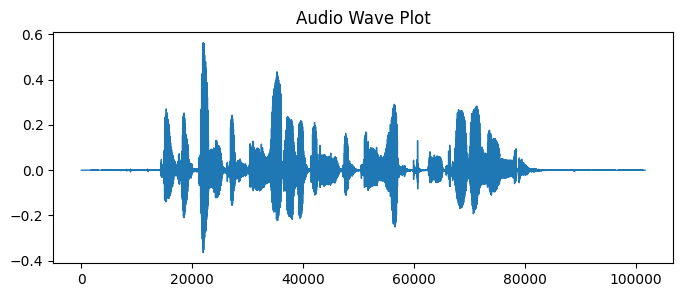

In [ ]:
data, sr = librosa.load(sample)

print("Sampling Rate : "+ str(librosa.get_samplerate(sample))+"Hz")
print("Duration : "+ str(librosa.get_duration(filename=sample))+"s")

# Shape of features
print("Shape of Initial Data : "+ str(data.shape))


pd.Series(data).plot(figsize=(8, 3), lw=1)
plt.title('Audio Wave Plot')
plt.show()

### Recortamos el silencio

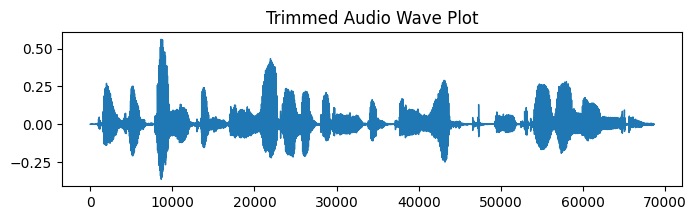

In [ ]:
trimmed_x, index = librosa.effects.trim(data, top_db=35)
pd.Series(trimmed_x).plot(figsize=(8, 2), lw=1)
plt.title('Trimmed Audio Wave Plot')
plt.show()

### Reducimos el ruido

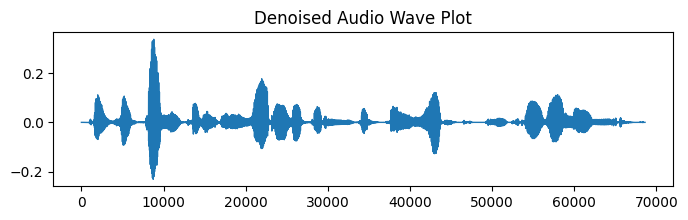

In [ ]:
denoised_x = nr.reduce_noise(y=trimmed_x, sr=sr)

pd.Series(denoised_x).plot(figsize=(8, 2), lw=1)
plt.title('Denoised Audio Wave Plot')
plt.show()

### Normalización

In [ ]:
normalized_x = librosa.util.normalize(denoised_x)

### Remuestreo

In [ ]:
resampled_x = librosa.resample(data, orig_sr=sr, target_sr=16000)

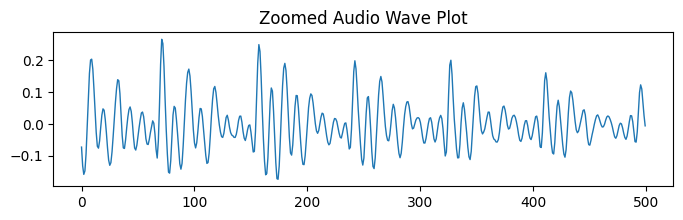

In [ ]:
pd.Series(denoised_x[9000:9500]).plot(figsize=(8, 2), lw=1)
plt.title('Zoomed Audio Wave Plot')
plt.show()

# Preprocesamiento de los audios

In [ ]:
SAMPLE_RATE = 16000 # Standard rate for speech models
DURATION = 3 # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

## Guía de preprocesamiendo de audio simple

In [ ]:
def PreprocessAudio(file_path):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # trim silence
        y, _ = librosa.effects.trim(y)

        # reduce noise
        y = nr.reduce_noise(y=y, sr=sr)

        # normalize
        y = librosa.util.normalize(y)

        # padding/truncating
        if len(y) < SAMPLES_PER_TRACK:
            y = np.pad(y, (0, SAMPLES_PER_TRACK - len(y)))
        else:
            y = y[:SAMPLES_PER_TRACK]

        return y, sr
    except Exception as error:
        print(f"Failed to process '{file_path}': {error}")
        return None, None

## Guía de extracción de características

In [ ]:
# Función para extracción de caracteristicas
def extract_gender_features(audio_file):
    '''original function used to exract the csv file'''
    y, sr = librosa.load(audio_file, sr=None)

    # Spectral Features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

    # Temporal Features
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    rms_energy = librosa.feature.rms(y=y)

    # Pitch Features
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    fundamental_freqs = pitches[pitches > 0]
    mean_pitch = np.mean(fundamental_freqs) if len(fundamental_freqs) > 0 else 0
    min_pitch = np.min(fundamental_freqs) if len(fundamental_freqs) > 0 else 0
    max_pitch = np.max(fundamental_freqs) if len(fundamental_freqs) > 0 else 0
    std_pitch = np.std(fundamental_freqs) if len(fundamental_freqs) > 0 else 0

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfccs, axis=1)
    mfcc_std = np.std(mfccs, axis=1)

    # Statistical Features
    spectral_values = spectral_centroid[0]
    spectral_skew = skew(spectral_values)
    spectral_kurtosis = kurtosis(spectral_values)

    # Energy-Based Features
    energy_entropy = -np.sum(rms_energy * np.log2(rms_energy + 1e-12))
    log_energy = np.log(np.sum(rms_energy))

    features = {
        "mean_spectral_centroid": np.mean(spectral_centroid),
        "std_spectral_centroid": np.std(spectral_centroid),
        "mean_spectral_bandwidth": np.mean(spectral_bandwidth),
        "std_spectral_bandwidth": np.std(spectral_bandwidth),
        "mean_spectral_contrast": np.mean(spectral_contrast),
        "mean_spectral_flatness": np.mean(spectral_flatness),
        "mean_spectral_rolloff": np.mean(spectral_rolloff),
        "zero_crossing_rate": np.mean(zero_crossing_rate),
        "rms_energy": np.mean(rms_energy),
        "mean_pitch": mean_pitch,
        "min_pitch": min_pitch,
        "max_pitch": max_pitch,
        "std_pitch": std_pitch,
        "spectral_skew": spectral_skew,
        "spectral_kurtosis": spectral_kurtosis,
        "energy_entropy": energy_entropy,
        "log_energy": log_energy,
    }

    for i, (mfcc_m, mfcc_s) in enumerate(zip(mfcc_mean, mfcc_std), start=1):
        features[f"mfcc_{i}_mean"] = mfcc_m
        features[f"mfcc_{i}_std"] = mfcc_s

    return features

## Diccionario de datos


In [52]:
metadata_df = pd.read_csv(diccionario_clips)
display(metadata_df.head())

,clip,duration[ms],age,gender,delta
0,common_voice_es_40923996.mp3,5256,adult,female,cv-corpus-19.0-delta-2024-09-13
1,common_voice_es_40923997.mp3,4608,adult,female,cv-corpus-19.0-delta-2024-09-13
2,common_voice_es_40923998.mp3,4788,adult,female,cv-corpus-19.0-delta-2024-09-13
3,common_voice_es_40923999.mp3,4608,adult,female,cv-corpus-19.0-delta-2024-09-13
4,common_voice_es_40924000.mp3,4068,adult,female,cv-corpus-19.0-delta-2024-09-13


## Preprocesamiento del audio y extración de característcas


In [73]:
SAMPLE_RATE = 16000 # Standard rate for speech models
DURATION = 3 # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def PreprocessAudio(file_path):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # trim silence
        y, _ = librosa.effects.trim(y)

        # reduce noise
        y = nr.reduce_noise(y=y, sr=sr)

        # normalize
        y = librosa.util.normalize(y)

        # padding/truncating
        if len(y) < SAMPLES_PER_TRACK:
            y = np.pad(y, (0, SAMPLES_PER_TRACK - len(y)))
        else:
            y = y[:SAMPLES_PER_TRACK]

        return y, sr
    except Exception as error:
        print(f"Failed to process '{file_path}': {error}")
        return None, None

# Function for feature extraction
def extract_gender_features(audio_data, sr):
    '''original function used to exract the csv file'''
    try:
        # Spectral Features
        spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)
        spectral_flatness = librosa.feature.spectral_flatness(y=audio_data)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr)

        # Temporal Features
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio_data)
        rms_energy = librosa.feature.rms(y=audio_data)

        # Pitch Features
        pitches, magnitudes = librosa.piptrack(y=audio_data, sr=sr)
        fundamental_freqs = pitches[pitches > 0]
        mean_pitch = np.mean(fundamental_freqs) if len(fundamental_freqs) > 0 else 0
        min_pitch = np.min(fundamental_freqs) if len(fundamental_freqs) > 0 else 0
        max_pitch = np.max(fundamental_freqs) if len(fundamental_freqs) > 0 else 0
        std_pitch = np.std(fundamental_freqs) if len(fundamental_freqs) > 0 else 0

        # MFCCs
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfccs, axis=1)
        mfcc_std = np.std(mfccs, axis=1)

        # Statistical Features
        spectral_values = spectral_centroid[0]
        spectral_skew = skew(spectral_values)
        spectral_kurtosis = kurtosis(spectral_values)

        # Energy-Based Features
        energy_entropy = -np.sum(rms_energy * np.log2(rms_energy + 1e-12))
        log_energy = np.log(np.sum(rms_energy))

        features = {
            "mean_spectral_centroid": np.mean(spectral_centroid),
            "std_spectral_centroid": np.std(spectral_centroid),
            "mean_spectral_bandwidth": np.mean(spectral_bandwidth),
            "std_spectral_bandwidth": np.std(spectral_bandwidth),
            "mean_spectral_contrast": np.mean(spectral_contrast),
            "mean_spectral_flatness": np.mean(spectral_flatness),
            "mean_spectral_rolloff": np.mean(spectral_rolloff),
            "zero_crossing_rate": np.mean(zero_crossing_rate),
            "rms_energy": np.mean(rms_energy),
            "mean_pitch": mean_pitch,
            "min_pitch": min_pitch,
            "max_pitch": max_pitch,
            "std_pitch": std_pitch,
            "spectral_skew": spectral_skew,
            "spectral_kurtosis": spectral_kurtosis,
            "energy_entropy": energy_entropy,
            "log_energy": log_energy,
        }

        for i, (mfcc_m, mfcc_s) in enumerate(zip(mfcc_mean, mfcc_std), start=1):
            features[f"mfcc_{i}_mean"] = mfcc_m
            features[f"mfcc_{i}_std"] = mfcc_s

        return features
    except Exception as error:
        print(f"Failed to extract features for audio data: {error}")
        return None


features_list = []
for filename in tqdm(archivos_mp3):
    file_path = os.path.join(ruta_clips, filename)
    preprocessed_audio, sr = PreprocessAudio(file_path)

    if preprocessed_audio is None or sr is None:
        print(f"Skipping '{filename}' due to processing error.")
        continue

    # Apply the feature extraction function to the preprocessed audio data
    features = extract_gender_features(preprocessed_audio, sr)

    if features is None:
        print(f"Skipping '{filename}' due to feature extraction error.")
        continue

    # Get the gender label for the current file
    gender_label = metadata_df[metadata_df['clip'] == filename]['gender'].values[0]
    # Get the age label for the current file
    age_label = metadata_df[metadata_df['clip'] == filename]['age'].values[0]

    # Store the features and labels
    features['gender'] = gender_label
    features['age'] = age_label
    features_list.append(features)

 44%|████▍     | 1313/2998 [03:37<03:59,  7.04it/s]/usr/local/lib/python3.12/dist-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
 44%|████▍     | 1315/2998 [03:37<03:30,  7.98it/s]

Failed to process '/content/drive/MyDrive/Septimo ciclo/Mineria de datos/Proyecto/Mineria de datos/clips/common_voice_es_41574755.mp3': Input must be finite
Skipping 'common_voice_es_41574755.mp3' due to processing error.


 44%|████▍     | 1317/2998 [03:37<03:07,  8.95it/s]

Failed to process '/content/drive/MyDrive/Septimo ciclo/Mineria de datos/Proyecto/Mineria de datos/clips/common_voice_es_41574752.mp3': Input must be finite
Skipping 'common_voice_es_41574752.mp3' due to processing error.


100%|██████████| 2998/2998 [08:12<00:00,  6.09it/s]


## Verificamos contenido del CSV

In [76]:
output_csv_path = os.path.join(ruta_clips, 'audio_features_with_gender_and_age.csv')
verified_df = pd.read_csv(output_csv_path)
display(verified_df.head())
print(f"\nTotal number of rows in the generated CSV: {len(verified_df)}")

,mean_spectral_centroid,std_spectral_centroid,mean_spectral_bandwidth,std_spectral_bandwidth,mean_spectral_contrast,mean_spectral_flatness,mean_spectral_rolloff,zero_crossing_rate,rms_energy,mean_pitch,...,mfcc_10_mean,mfcc_10_std,mfcc_11_mean,mfcc_11_std,mfcc_12_mean,mfcc_12_std,mfcc_13_mean,mfcc_13_std,gender,age
0,2523.231827,1832.982941,1149.654083,526.589132,33.620332,0.055383,3647.606383,0.237824,0.091509,1751.8302,...,-3.666552,14.875398,-2.921302,14.467586,-17.671968,19.096952,-2.169926,18.751070,female,senior
1,1542.213606,1001.261703,1316.990525,641.044093,35.872289,0.014409,2649.850399,0.136360,0.066259,1329.4478,...,-19.792757,20.329224,-10.728235,16.504880,-16.580048,15.173723,-0.316641,14.779031,female,senior
2,2179.993253,1543.676335,1444.146313,675.637252,31.597122,0.117705,3679.936835,0.179589,0.061753,1308.2037,...,-19.839151,18.979174,-4.228754,12.908400,-11.578573,12.454902,2.165149,17.419746,female,senior
3,2301.647978,2046.331134,1019.403659,636.872378,27.819356,0.408344,2940.076463,0.160406,0.043503,1389.5989,...,-15.956167,18.503403,-2.361630,12.041576,-11.663919,14.523246,-3.108305,12.931184,female,senior
4,2025.016079,1705.281012,1226.477797,738.085532,30.073968,0.135017,3010.555186,0.139893,0.062947,1109.6190,...,-17.986880,20.490236,-5.098342,14.033310,-16.245848,16.547665,3.459704,16.467356,female,senior



Total number of rows in the generated CSV: 2996
